### Importa librerie

In [1]:
print("Loading...")

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import re

import cv2
from PIL import Image

import keras
from keras import backend as K
from keras.models import load_model
from keras.layers import *

import tkinter as tk
from PIL import Image, ImageDraw

K.image_data_format()

print("Done")

Loading...
Done


### Carica un modello pre-addestrato

In [42]:
# Carica il modello
model = load_model('pre-trained-models/eq_solver4.keras')

### Carica un'immagine

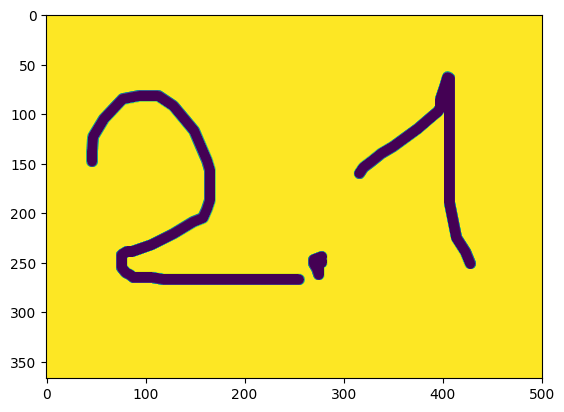

In [46]:
img = cv2.imread('images_for_test/testIMG666.png',cv2.IMREAD_GRAYSCALE)
plt.imshow(img)


#### - Valutazione dell'immagine

In [47]:
if img is not None:
    img=~img
    _,thresh=cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    ctrs,_=cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    w=int(28)
    h=int(28)
    train_data=[]
    print(len(cnt))
    rects=[]
    for c in cnt :
        x,y,w,h= cv2.boundingRect(c)
        rect=[x,y,w,h]
        rects.append(rect)
    bool_rect=[]
    for r in rects:
        l=[]
        for rec in rects:
            flag=0
            if rec!=r:
                if r[0]<(rec[0]+rec[2]+10) and rec[0]<(r[0]+r[2]+10) and r[1]<(rec[1]+rec[3]+10) and rec[1]<(r[1]+r[3]+10):
                    flag=1
                l.append(flag)
            if rec==r:
                l.append(0)
        bool_rect.append(l)
    dump_rect=[]
    for i in range(0,len(cnt)):
        for j in range(0,len(cnt)):
            if bool_rect[i][j]==1:
                area1=rects[i][2]*rects[i][3]
                area2=rects[j][2]*rects[j][3]
                if(area1==min(area1,area2)):
                    dump_rect.append(rects[i])
    print(len(dump_rect)) 
    final_rect=[i for i in rects if i not in dump_rect]
    print(final_rect)
    for r in final_rect:
        x=r[0]
        y=r[1]
        w=r[2]
        h=r[3]
        im_crop =thresh[y:y+h+10,x:x+w+10]
        im_resize = cv2.resize(im_crop,(28,28))
        im_resize=np.reshape(im_resize,(28,28,1))
        train_data.append(im_resize)

3
1
[[41, 77, 220, 196], [311, 58, 123, 199]]


### Valuta l'espressione e risolvila

In [48]:
equation = ''

# Simulazione del processo di lettura dei dati (puoi sostituire train_data e model con i tuoi)
for i in range(len(train_data)):
    train_data[i] = np.array(train_data[i])
    train_data[i] = train_data[i].reshape(1, 28, 28, 1)
    result = np.argmax(model.predict(train_data[i]), axis=-1)

    for j in range(10):
        if result[0] == j:
            equation = equation + str(j)

    if result[0] == 10:
        equation = equation + "+"
    if result[0] == 11:
        equation = equation + "-"
    if result[0] == 12:
        equation = equation + "*"
    if result[0] == 13:
        equation = equation + "/"
    if result[0] == 14:
        equation = equation + "="
    if result[0] == 15:
        equation = equation + "."
    if result[0] == 16:
        equation = equation + "x"
    if result[0] == 17:
        equation = equation + "y"
    if result[0] == 18:
        equation = equation + "z"

print("Your Equation:", equation)

# Verifica se c'è un segno di uguale nell'equazione
if "=" in equation:
    left_side, right_side = equation.split('=')

    print("left_side =", left_side)
    print("right_side =", right_side)

    # Verifica se la parte sinistra è la definizione di una variabile (ad es. "y =")
    if left_side.strip() in ['x', 'y', 'z']:  # Variabili considerate
        variable_name = left_side.strip()

        # Cerchiamo un'assegnazione diretta del valore alla variabile
        direct_assignment = re.search(r'(\d+(\.\d+)?)', right_side)
        
        if direct_assignment:
            # Se troviamo un'assegnazione diretta, usiamo quel valore
            variable_value = float(direct_assignment.group(1))
        else:
            # Altrimenti, cerchiamo di risolvere l'equazione per la variabile
            try:
                # Rimuoviamo la variabile dal lato destro
                right_side_without_var = re.sub(r'\b' + variable_name + r'\b', '', right_side)
                # Risolviamo l'equazione
                variable_value = eval(right_side_without_var)
            except:
                print(f"Impossibile calcolare il valore di {variable_name}")
                variable_value = None

        if variable_value is not None:
            print(f"Il valore calcolato per {variable_name} è: {variable_value}")

            # Ora possiamo usare questo valore nell'espressione originale
            right_side_cleaned = re.sub(r'\d*\.?\d*\*?' + variable_name, variable_name, right_side)
            try:
                new_expression = right_side_cleaned.replace(variable_name, str(variable_value))
                # Sostituiamo il punto decimale con una virgola per evitare problemi con eval()
                new_expression = new_expression.replace(',', '.')
                final_result = eval(new_expression)
                print(f"Il risultato finale dell'espressione '{right_side_cleaned}' è:", final_result)
            except Exception as e:
                print("Errore durante la valutazione della nuova espressione:", e)
        else:
            print("Impossibile calcolare il risultato finale.")
    else:
        try:
            # Se non è una definizione di variabile, calcola normalmente
            result = eval(left_side)
            print("The result of the equation is:", result)
        except Exception as e:
            print("Error while evaluating the equation :", e)

else:
    # Se non c'è un segno di uguale, calcola direttamente l'espressione
    try:
        result = eval(equation)
        print("The result of the expression is:", result)
    except Exception as e:
        print("Error while evaluating the expression:", e)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Your Equation: 21
The result of the expression is: 21
